# Альтернативная система ОДУ первого порядка:
$$
\begin{cases}
\frac{dx}{dt} = \omega_0 y + \frac{1}{\omega} \sin(\omega t) \\
\frac{dy}{dt} = -\omega_0 x \\
x(0) = x_0 \\
y(0) = \frac{v_0}{\omega_0}
\end{cases}
$$

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

# Установка папки для сохранения по умолчанию
SAVE_DIR = "images"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_plot(filename: str, dpi=300):
    filepath = os.path.join(SAVE_DIR, filename)
    plt.savefig(filepath, dpi=dpi, bbox_inches="tight")

# Установка устройства для вычислений (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [2]:
# Определение области определения
t_min, t_max = -5.0, 15.0

# Количество точек внутри области и на границе
num_interior = round(t_max - t_min)*20

t = torch.linspace(t_min, t_max, num_interior).view(-1, 1).to(device)
t.requires_grad = True

x_boundary = torch.tensor([[0.0]], requires_grad=True).to(device)
y_boundary = torch.tensor([[0.0]], requires_grad=True).to(device)

In [3]:
# Определение нейронной сети
class Sine(nn.Module):
    def __init__(self):
        super(Sine, self).__init__()

    def forward(self, input):
        return torch.sin(2*input)

# Определение нейронной сети
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Задаем архитектуру: 3 скрытых слоя по 20 нейронов с функцией активации Tanh
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 20),
            Sine(),
            nn.Linear(20, 2)
        )

    def forward(self, x):
        return self.net(x)

Параметры для запуска:
 - $w = w_f = 2, f_a = 0.25, v_0 = 1$ для резонанса
 - $w = 2, w_f = 2.5, f_a = 2, v_0 = 1$ для его отсутствия

In [4]:
w = 2.0
w_f = 2.5
f_a = 2
v0 = 1

# Инициализация модели
model = PINN().to(device)

# Определение функции потерь
def loss_function(t, x_boundary, y_boundary, x_boundary_val, y_boundary_val, lambda_bc=1.0):
    # Предсказания модели на внутренних точках
    result = model(t)
    x_interior = result[:, 0].view(-1, 1)
    y_interior = result[:, 1].view(-1, 1)
    x_calc = model(x_boundary)[:, 0].view(-1, 1)
    y_calc = model(y_boundary)[:, 1].view(-1, 1)

    # Вычисление производной dy/dx с помощью автоматического дифференцирования
    dx_dt = torch.autograd.grad(
        x_interior, t,
        grad_outputs=torch.ones_like(x_interior),
        create_graph=True
    )[0]

    # Вычисление 2 производной dy/dx с помощью автоматического дифференцирования
    dy_dt = torch.autograd.grad(
        y_interior, t,
        grad_outputs=torch.ones_like(y_interior),
        create_graph=True
    )[0]

    # Вычисление функции дифференциального уравнения на внутренних точках (residual)
    residual = w * y_interior - (f_a / w_f) * torch.sin(t * w_f) - dx_dt
    residual2 = dy_dt + w * x_interior

    # Потери на уравнении (MSE по residual)
    loss_interior = torch.mean(residual**2) + torch.mean(residual2 **2)

    # Потери на граничных условиях (MSE между предсказанием и истинным значением)
    loss_boundary = torch.mean((y_calc - y_boundary_val)**2) + torch.mean((x_calc - x_boundary_val)**2)

    loss = loss_interior + lambda_bc * loss_boundary
    return loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10000

loss_history = []


y_boundary_val = torch.tensor([[1.0/w]], requires_grad=True).to(device)
x_boundary_val = torch.tensor([[0.0]], requires_grad=True).to(device)
lambda_bc = 50

# Цикл обучения с использованием tqdm
best_loss = float('inf')
best_model_state_dict = None

pbar = tqdm(range(num_epochs), desc='Training', ncols=80)
for epoch in pbar:
    optimizer.zero_grad()
    loss = loss_function(t, x_boundary, y_boundary, x_boundary_val, y_boundary_val, lambda_bc)

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state_dict = model.state_dict()

    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    # Обновление отображения tqdm
    pbar.set_postfix({'Loss': f'{loss.item():.2e}'})

if best_model_state_dict is not None:
    model.load_state_dict(best_model_state_dict)
    print(f"Restored the model with the best loss: {best_loss:.2e}")

Training:   0%|                                       | 0/10000 [00:00<?, ?it/s]

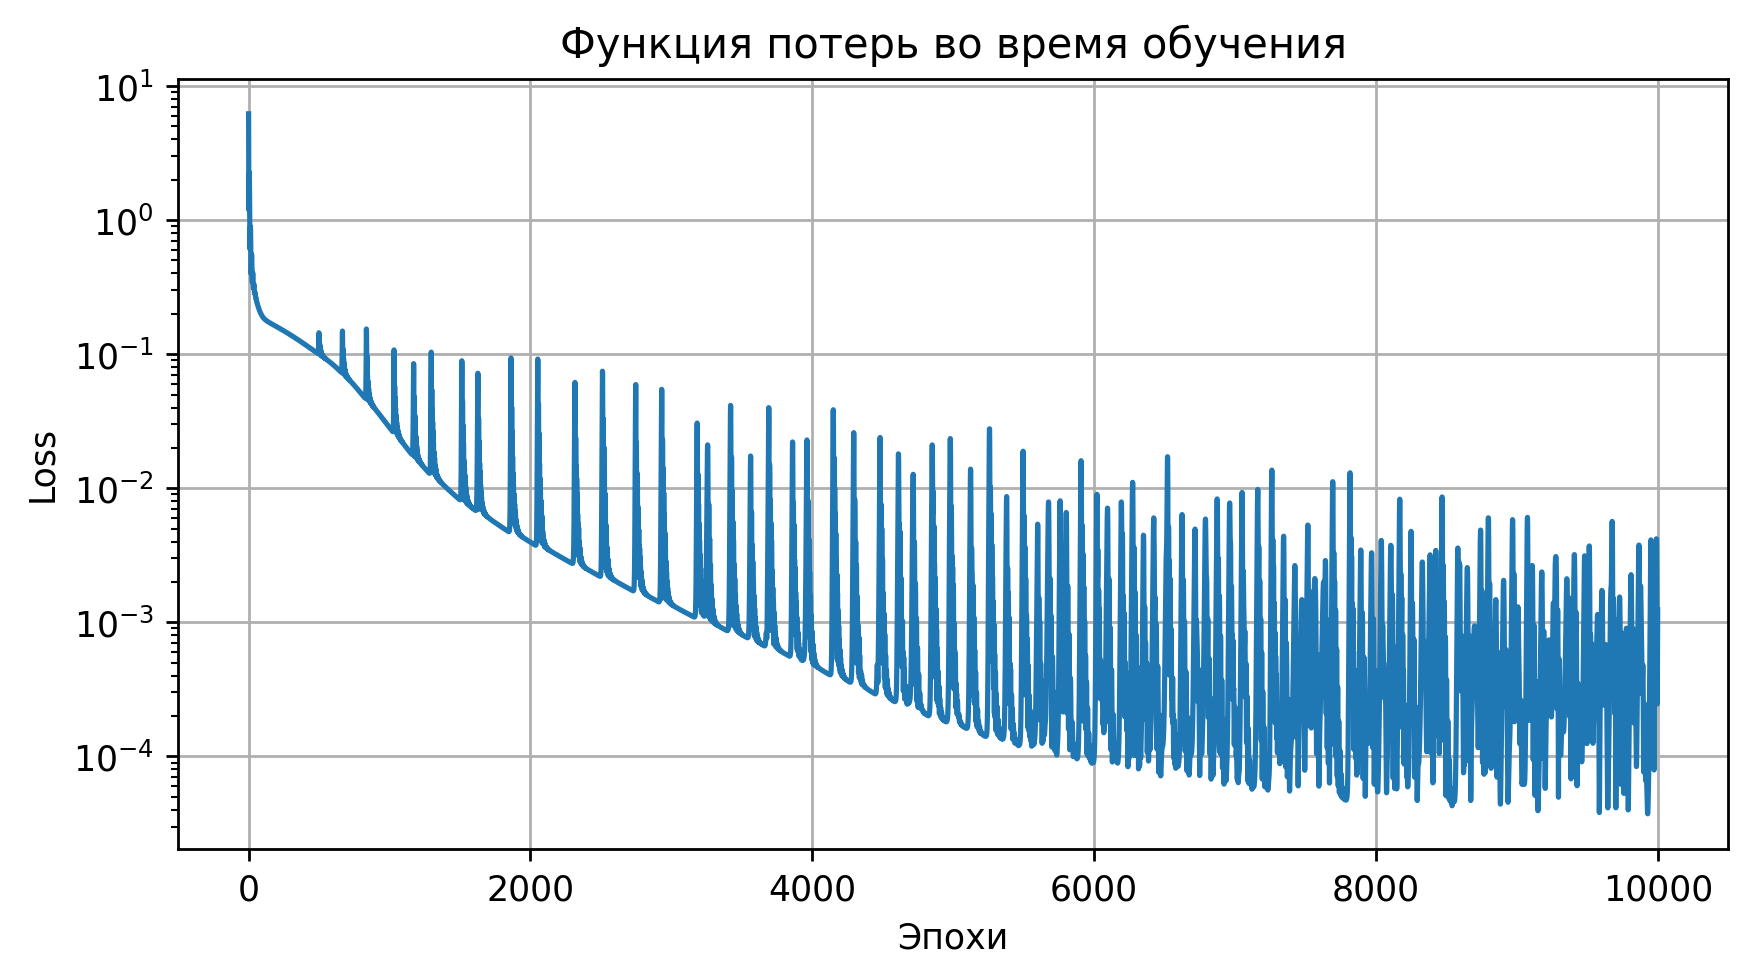

tensor(0.0013, device='cuda:0', grad_fn=<AddBackward0>)

In [5]:
# Построение графика функции потерь в логарифмическом масштабе
plt.figure(figsize=(8, 4), dpi=250)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Функция потерь во время обучения')
plt.grid(True)
save_plot("Loss_alt_ODE.png")
plt.show()
loss_function(t, x_boundary, y_boundary, x_boundary_val, y_boundary_val, lambda_bc)

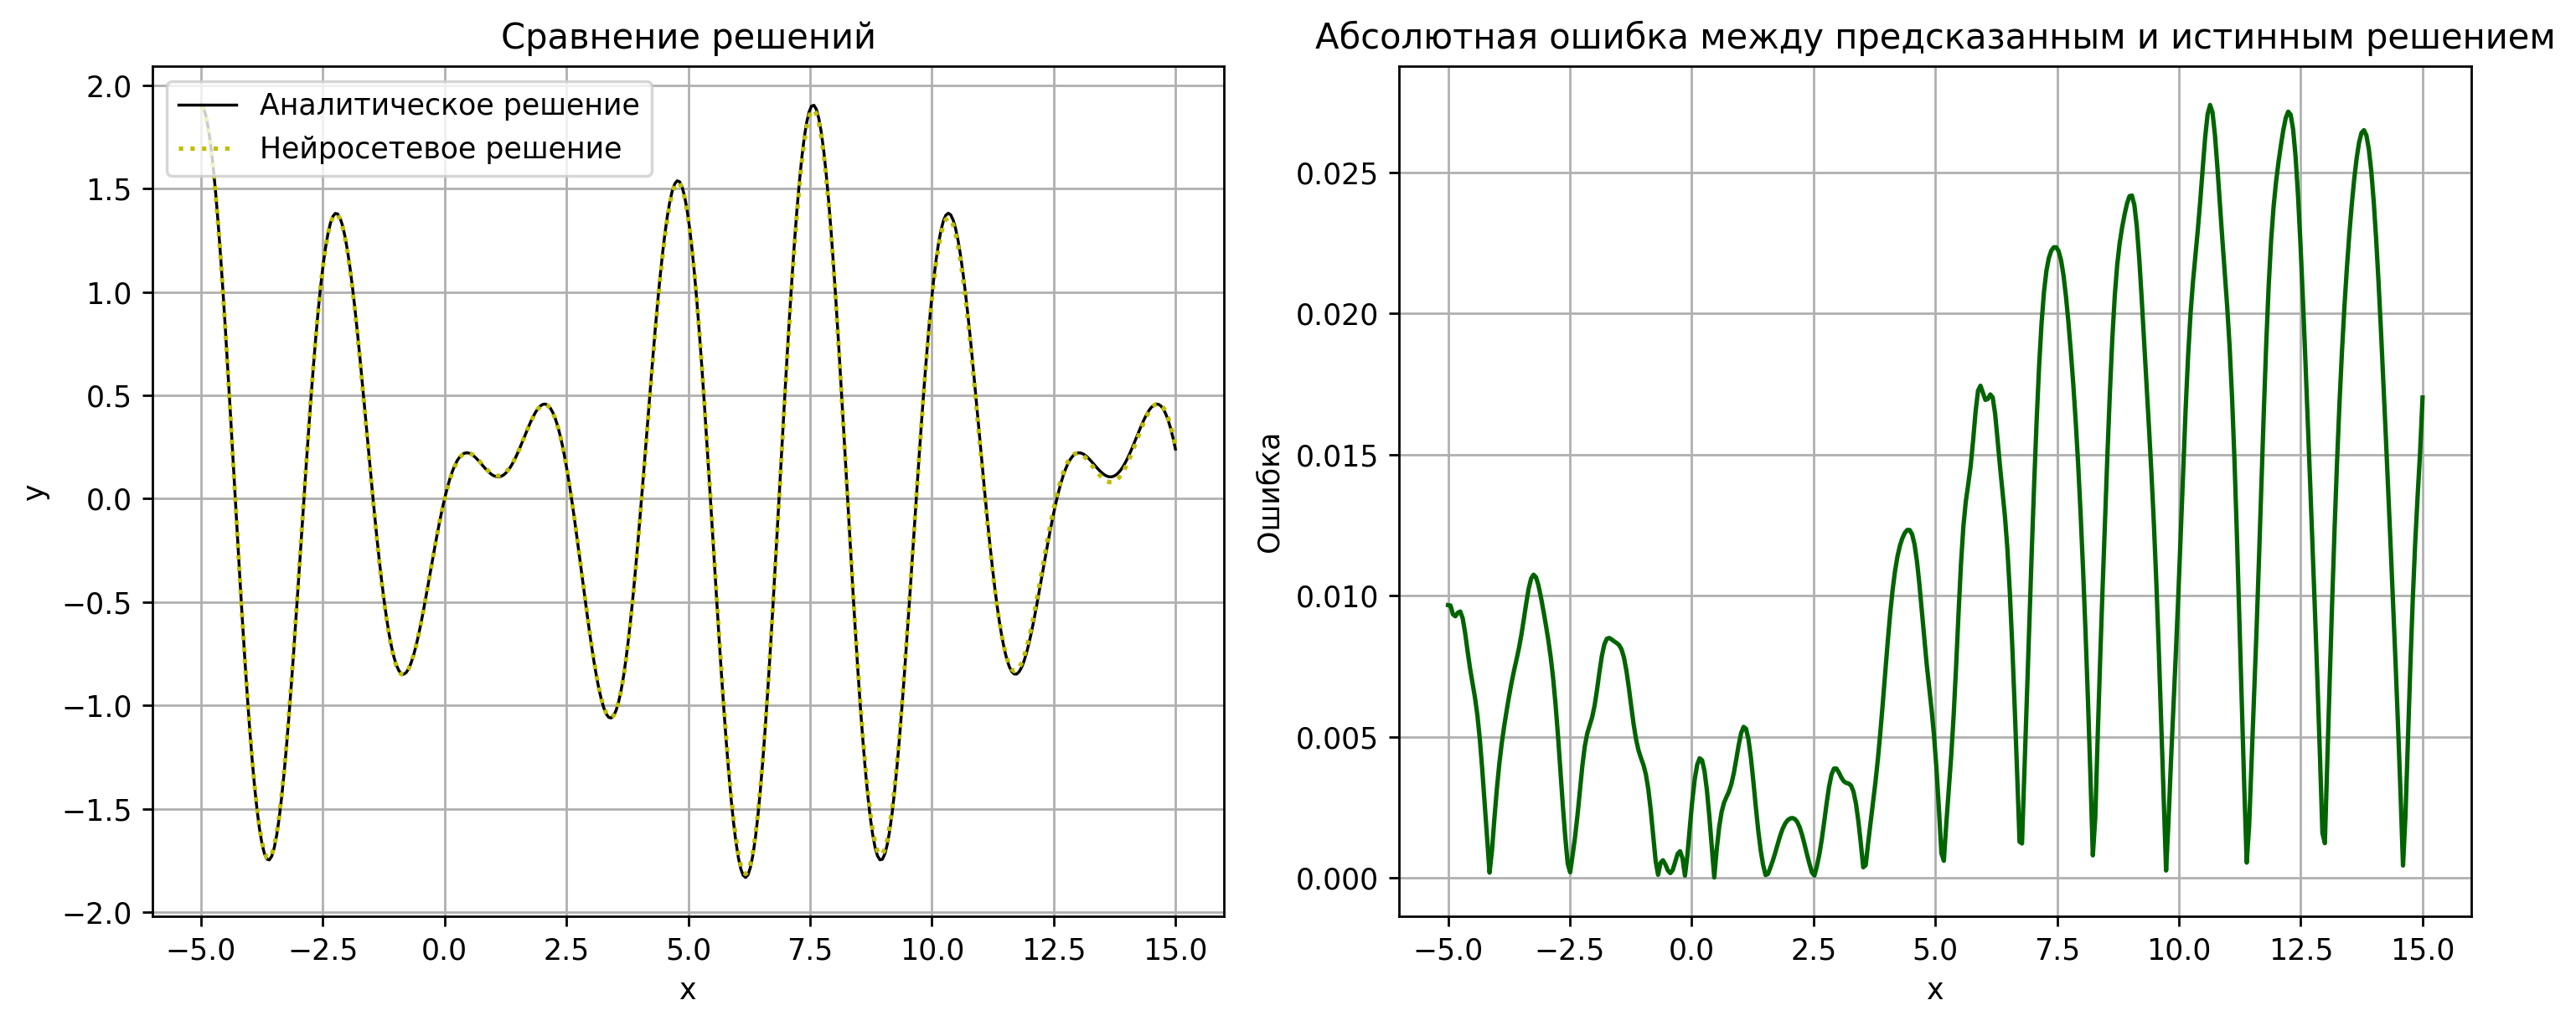

np.float32(0.009874348)

In [6]:
x_l, x_r = -5, 15
cnt = 20
x_plot = torch.linspace(x_l, x_r , (x_r - x_l)*cnt).view(-1, 1).to(device)

# Аналитическое решение
x_p = x_plot.cpu().detach().numpy()
if w == w_f:
  y_true = (1/w - f_a*x_p/(2*w))*np.sin(w * x_p)
else:
  y_true = f_a*(np.cos(w * x_p) - np.cos(w_f * x_p))/(w**2 - w_f**2) + np.sin(w*x_p)/w

# Предсказание решения моделью
y_pred = model(x_plot).cpu().detach().numpy()[:, 0][:, np.newaxis]

x_plot = x_plot.cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(y_true - y_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_true, label='Аналитическое решение', linewidth = 1, color='k')
plt.plot(x_plot, y_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(x_plot, absolute_error, color='darkgreen')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

plt.tight_layout()
save_plot("x_alt_ODE.png")
plt.show()
np.mean(absolute_error)

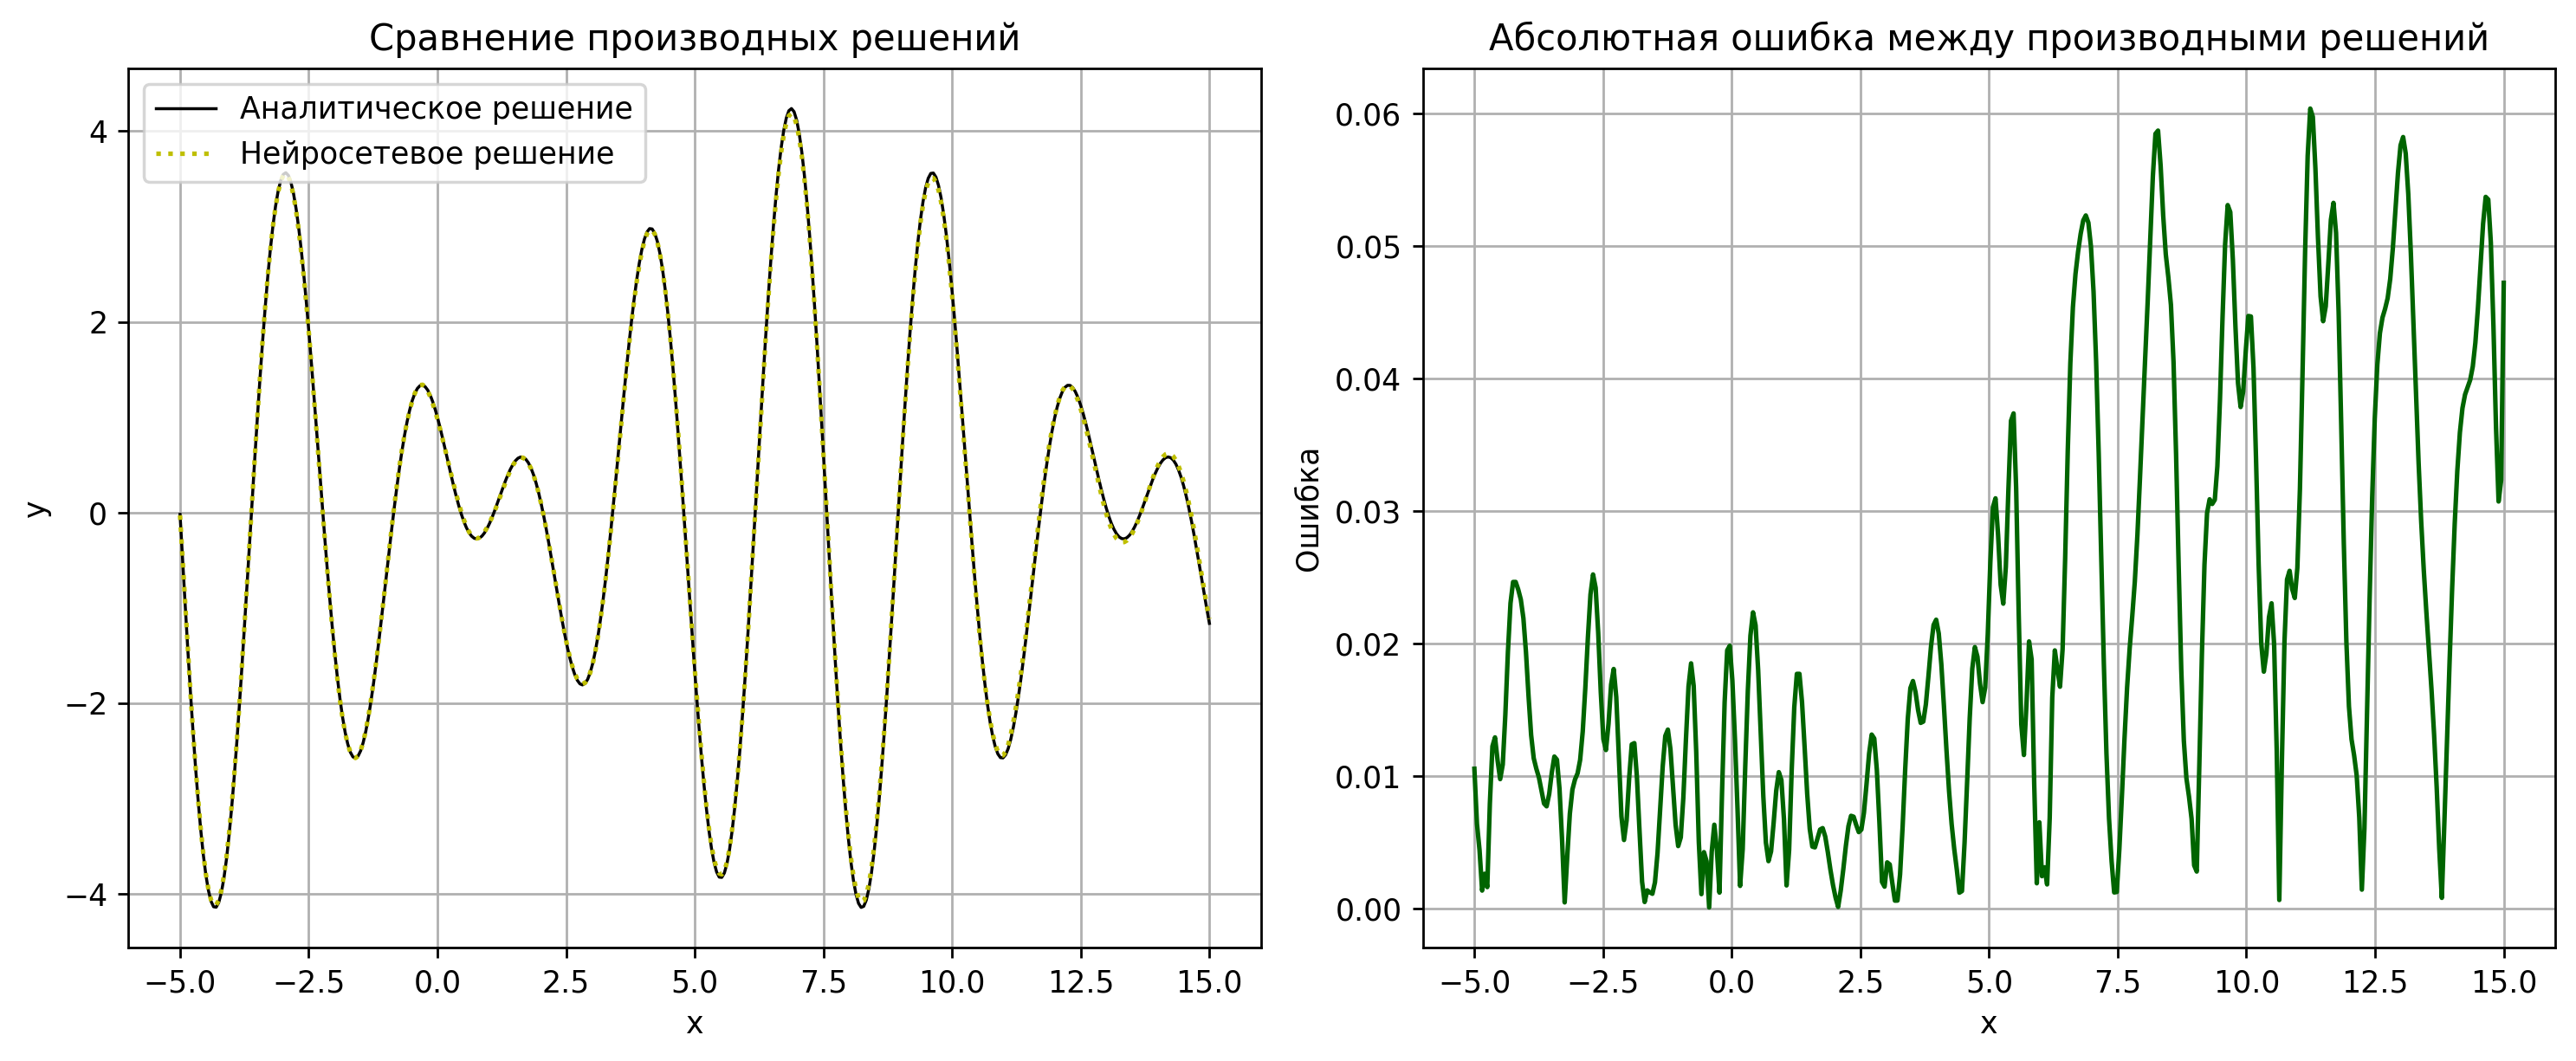

np.float32(0.02079969)

In [7]:
x_l, x_r = -5, 15
cnt = 20
x_plot = torch.linspace(x_l, x_r , (x_r - x_l)*cnt, requires_grad = True).view(-1, 1).to(device)

# Аналитическое решение
x_p = x_plot.cpu().detach().numpy()
if w == w_f:
  y_true = (1 - f_a*x_p/2)*np.cos(w * x_p) - (f_a/(2*w))*np.sin(w * x_p)
else:
  y_true = f_a*(- w * np.sin(w * x_p) + w_f * np.sin(w_f * x_p))/(w**2 - w_f**2) + w * np.cos(w*x_p)/w

# Предсказание решения моделью
y_pred_x = model(x_plot)[:, 0].view(-1, 1)

y_pred = torch.autograd.grad(
        y_pred_x, x_plot,
        grad_outputs=torch.ones_like(y_pred_x),
        create_graph=True
    )[0].cpu().detach().numpy()

x_plot = x_plot.cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(y_true - y_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_true, label='Аналитическое решение', linewidth = 1, color='k')
plt.plot(x_plot, y_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение производных решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(x_plot, absolute_error, color='darkgreen')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между производными решений')
plt.grid(True)

plt.tight_layout()
save_plot("v_alt_ODE.png")
plt.show()
np.mean(absolute_error)